# TSSL Lab 2 - Structural model, Kalman filtering and EM
We will continue to work with the Global Mean Sea Level (GMSL) data that we got acquainted with in lab 1. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

In this lab we will analyse this data using a structural time series model. We will first set up a model and implement a Kalman filter to infer the latet states of the model, as well doing long-term prediction. We will then implement a disturbance smoother and an expectation maximization algorithm to tune the parameters of the model. 

We load a few packages that are useful for solving this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import scipy.linalg
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)  # Increase default size of plots

## 2.1 Setting up a structural state space model

We start by loading and plotting data to remind ourselves what it looks like.

In [2]:
data=pandas.read_csv('sealevel.csv',header=0)

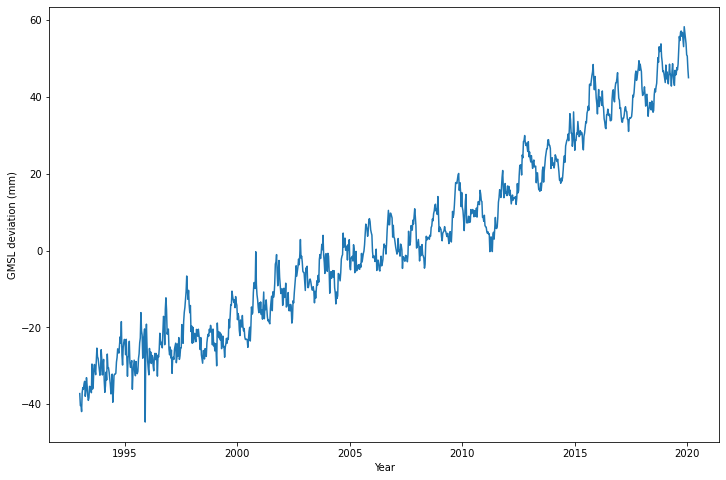

In [3]:
y = data['GMSL'].values
u = data['Year'].values
ndata = len(y)
plt.plot(u,y)
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.show()

In this lab we will use a structural time series model to analys this data set. Specifically, we assume that the data $\{y_t\}_{t\geq 1}$ is generated by

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

where $\mu_t$ is a trend component, $\gamma_t$ is a seasonal component, and $\varepsilon_t$ is an observation noise. The model is expressed using a state space representation,

\begin{align}
    \alpha_{t+1} &= T \alpha_t + R\eta_t, & \eta_t&\sim N(0,Q), \\
    y_t &= Z \alpha_t + \varepsilon_t, & \varepsilon_t&\sim N(0,\sigma_\varepsilon^2).
\end{align}

**Q0:** Let $d = \dim(\alpha_t)$ denote the _state dimension_ and $d_\eta = \dim(\eta_t)$ denote the dimension of the state noise. Then, what are the dimenisons of the matrices $T$, $R$, and $Z$ of the state space model?

**A:** The matrices of the state space model can be expressed in terms of the dimensions of the state and state noise as follows:

$T$ has dimensions $d$ x $d$    
$R$ has dimensions $d$ x $d_\eta$  
$Z$ has dimensions $1$ x $d$

**Q1:** Create the state space matrices $T_{[\mu]}$, $R_{[\mu]}$, and $Z_{[\mu]}$ corresponding to the trend component $\mu_t$. We assume a local linear trend (that is, of order $k=2$). 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [4]:
# State space matrices corresponding to the trend component
k = 2
T_mu = np.zeros(shape=(k, k))
R_mu = np.zeros(shape=(k, 1))
Z_mu = np.zeros(shape=(1, k))

# Function to compute factorial
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

# Fill in the state space matrices, T, R and Z
T_mu[0, ] = [(-1)**(i+2) * nCr(k, i+1) for i in range(k)]
for i in range(1, k): 
    T_mu[i, i-1] = 1
    
R_mu[0, 0] = 1
Z_mu[0, 0] = 1

In [5]:
print("Matrix T for the trend component : \n", T_mu)
print("Matrix R for the trend component : \n", R_mu)
print("Matrix Z for the trend component : \n", Z_mu)

Matrix T for the trend component : 
 [[ 2. -1.]
 [ 1.  0.]]
Matrix R for the trend component : 
 [[1.]
 [0.]]
Matrix Z for the trend component : 
 [[1. 0.]]


**Q2:** There is a yearly seasonal pattern present in the data. What should we set the periodicity $s$ of the seasonal component to, to capture this pattern?

_Hint:_ Count the average number of observations per (whole) year and round to the closest integer.

In [6]:
# Calculate average counts per year in the observations
years = data['Year'].astype(str).str[0:4]
yearCounts = years.value_counts()

print(yearCounts)
print("Average number of observations per year : ", yearCounts.mean())

2017    37
2019    37
2009    37
2007    37
2013    37
2012    37
1994    37
2000    37
1993    37
2003    37
2005    37
1997    37
1999    37
2001    37
2015    37
2011    37
1995    37
2006    37
2016    37
2018    37
1998    37
2010    37
2004    37
1996    36
2002    36
2014    36
2008    36
2020     2
Name: Year, dtype: int64
Average number of observations per year :  35.607142857142854


In [7]:
# Calculate average counts per year in the observations excluding the two data points at the end limit
yearCounts = years[:-2].value_counts()
print("Average number of observations per year (excluding the two observations made in 2020): ", yearCounts.mean())

Average number of observations per year (excluding the two observations made in 2020):  36.851851851851855


The periodicity s should be set to 37 in order to capture the yearly seasonal pattern present in the data.

**Q3:** What is the _state dimension_ of a seasonal component with periodicity $s$? That is, how many states are needed in the corresponding state space representation?

**A:** The state dimension of the seasonal component is (s-1)*(s-1) = 36 x 36 i.e. 36 states are needed in the state space representation of a seasonal component model with periodicity s=37. 

**Q4:** Create the state space matrices $T_{[\gamma]}$, $R_{[\gamma]}$, and $Z_{[\gamma]}$ corresponding to the seasonal component $\gamma_t$. 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [8]:
# State space matrices corresponding to the seasonal component
s = 37
T_gamma = np.zeros(shape=(s-1, s-1))
R_gamma = np.zeros(shape=(s-1, 1))
Z_gamma = np.zeros(shape=(1, s-1))

# Fill in the state space matrices, T, R and Z
T_gamma[0, ] = -1
for i in range(1, s-1):
    T_gamma[i, i-1] = 1

R_gamma[0, 0] = 1
Z_gamma[0, 0] = 1

In [9]:
print("Matrix T for the seasonal component : \n", T_gamma)
print("Matrix R for the seasonal component : \n", R_gamma)
print("Matrix Z for the seasonal component : \n", Z_gamma)

Matrix T for the seasonal component : 
 [[-1. -1. -1. ... -1. -1. -1.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  1.  0.]]
Matrix R for the seasonal component : 
 [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Matrix Z for the seasonal component : 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**Q5:** Using the matrices that you have constructed above, create the state space matrices for the complete structural time series model. Print out the shapes of the resulting system matrices and check that they correspond to what you expect (cf **Q0**).

_Hint:_ Use `scipy.linalg.block_diag` and `numpy.concatenate`.

In [10]:
# State space matrices for the complete structural time series model
T = scipy.linalg.block_diag(T_mu, T_gamma)
R = scipy.linalg.block_diag(R_mu, R_gamma)
Z = np.concatenate((Z_mu, Z_gamma), axis=1)

# Print the dimensions 
print("Dimensions of T : ", T.shape)
print("Dimensions of R : ", R.shape)
print("Dimensions of Z : ", Z.shape)

Dimensions of T :  (38, 38)
Dimensions of R :  (38, 2)
Dimensions of Z :  (1, 38)


The dimensions of the state space matrices for the complete structural time series model checks out with our expectations in question 0. Here $d = 38$ and $d_\eta = 2$.

We also need to specify the variances of the process noise $\eta_t$ and measurement noise $\varepsilon_t$. Below, we will estimate (two of) these variances from data, but for now we set them arbitrarily to get an initial model to work with.

In [11]:
# Some arbitrary noise values for now
sigma_trend = 0.01
sigma_seas = 1
sigma_eps = 1
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix

Finally, to complete the model we need to specify the distribution of the initial state. This encodes our _a priori_ belief about the actual values of the trend and seasonality, i.e., before observing any data.

**Q6:** Set up the mean vector of the initial state $a_1 = \mathbb{E}[\alpha_1]$ such that:
* The trend component starts at the first observation, $\mathbb{E}[\mu_1] = y_1$,
* The slope of the trend is _a priori_ zero in expectation, $\mathbb{E}[\mu_1 - \mu_0] = 0$,
* The initial mean of all states related to the seasonal component are zero.

Also, create an initial state covariance matrix $P_1 = \text{Cov}(\alpha_1)$ as an identity matrix of the correct dimension, multiplied with a large value (say, 100) to represent our uncertainty about the initial state.

In [12]:
# Initial state vector
d = k+s-1
a1 = np.zeros(shape=(d, 1))
a1[0, 0] = y[0]

# Initial state covariance matrix
P1 = np.identity(d) * 100

We have now defined all the matrices etc. that make up the structural state space model. For convenience, we can create an object of the class `LGSS` available in the module `tssltools_lab2` as a container for these quantities.

In [13]:
from tssltools_lab2 import LGSS  # Module available in LISAM
model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)

help(model.get_params)

Help on method get_params in module tssltools_lab2:

get_params() method of tssltools_lab2.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



## 2.2 Kalman filtering for the structural model
Now we have the data and a model available. Next, we will turn our attention to the inference problem, which is a central task when analysing time series data using the state space framework.

State inference is the problem of estimating the unknown (latent) state variables given the data. For the time being we assume that the _model parameters_ are completely specified, according to above, and only consider how to estimate the states using the Kalman filter.

In the questions below we will treat the first $n=800$ time steps as training data and the remaining $m=197$ observations as validation data. 

In [14]:
n = 800
m = ndata-n


**Q7:** Complete the Kalman filter implementation below. The function should be able to handle missing observations, which are encoded as "not a number", i.e. `y[t] = np.nan` for certain time steps `t`. 

_Hint:_ The Kalman filter involves a lot of matrix-matrix and matrix-vector multiplications. It turns out to be convient to store sequences of vectors (such as the predicted and filtered state estimates) as `(d,1,n)` arrays, instead of `(d,n)` or `(n,d)` arrays. In this way the matrix multiplications will result in 2d-arrays of the correct shapes without having to use a lot of explicit `reshape`. However, clearly, this is just a matter of coding style preferences!

In [15]:
from tssltools_lab2 import kfs_res  # Module available in LISAM. kfs_res is a container class for storing the result.

def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d  # State dimension
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params()  # Get all model parameters (for brevity)

    for t in range(n):
        # Time update (predict)
        if t == 0:  # Initialize predictions at first time step
            alpha_pred[:, :, t] = a1
            P_pred[:, :, t]     = P1
            
        else:  # All consecutive time steps
            alpha_pred[:, :, t] = T.dot(alpha_filt[:, :, t-1])
            P_pred[:, :, t]     = T.dot(P_filt[:, :, t-1].dot(T.T)) + R.dot(Q.dot(R.T))

        # Compute prediction of current output
        y_pred[t] = Z.dot(alpha_pred[:, :, t])
        F_pred[t] = Z.dot(P_pred[:, :, t].dot(Z.T)) + H

        # Measurement update (correct)
        if np.isnan(y[t]):  # Handle missing data
            alpha_filt[:, :, t] = alpha_pred[:, :, t]
            P_filt[:, :, t]     = P_pred[:, :, t]

        else:
            K = P_pred[:, :, t].dot(Z.T) / F_pred[t] # Kalman gain
            alpha_filt[:, :, t] = alpha_pred[:, :, t] + K.dot(y[t]-y_pred[t])
            P_filt[:, :, t]     = (np.identity(d) - K.dot(Z)).dot(P_pred[:, :, t])
            

    # Container for storing all results
    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf

**Q8:** Use the Kalman filter to infer the states of the structural time series applied to the sealevel data. Run the filter on the training data (i.e., first $n=800$ time steps), followed by a long-range prediction of $y_t$ for the remaining time points. 

Generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1$ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1$ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using, e.g., `plt.axvline(x=u[n])`.

_Hint:_ It is enough to call the `kalman_filter` function once. Make use of the missing data functionality!

Text(0, 0.5, 'GMSL deviation (mm)')

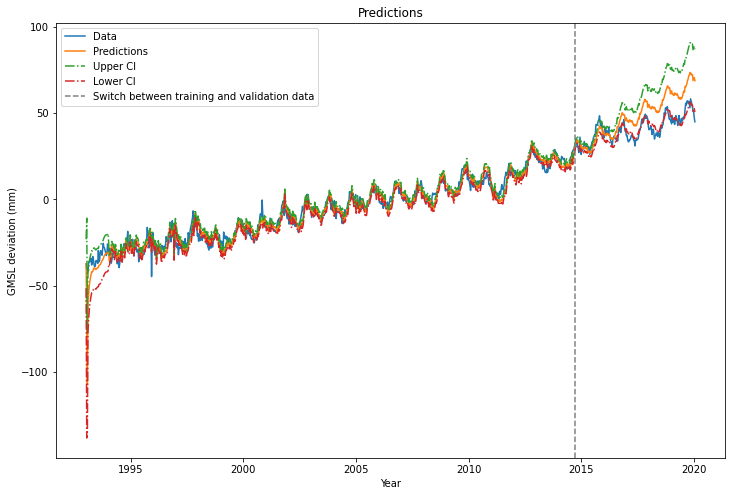

In [16]:
# Fill NaNs for m time steps to predict using the kalman filter
y_new = np.concatenate((y[:n], np.repeat(np.nan, m)))
kf = kalman_filter(y=y_new, model=model)

# Plot the data and predictions
plt.plot(u, y, label='Data')
plt.plot(u, kf.y_pred, label='Predictions')
plt.plot(u, kf.y_pred + np.sqrt(kf.F_pred), label='Upper CI', ls='-.')
plt.plot(u, kf.y_pred - np.sqrt(kf.F_pred), label='Lower CI', ls='-.')
plt.axvline(x=u[n], color='grey', ls='--', label='Switch between training and validation data')
plt.title('Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')

**Q9:** Based on the output of the Kalman filter, compute the training data log-likelihood $\log p(y_{1:n})$.

In [17]:
# Compute log-likelihood
def log_likelihood(y, y_hat, F):
    llik = -n/2*np.log(2*np.pi) - 1/2*np.sum(np.log(abs(F))+(y-y_hat).T/F*(y-y_hat))
    return(llik)

# Log-likelihood of training data based on the output of Kalman filter
llik = log_likelihood(y=y[:n], y_hat=kf.y_pred[:n], F=kf.F_pred[:n])
print("The log-likelihood of the training data : ", llik)

The log-likelihood of the training data :  -2848.96385321561


## 2.3 Identifying the noise variances using the EM algorithm
So far we have used fixed model parameters when running the filter. In this section we will see how the model parameters can be learnt from data using the EM algorithm. Specifically, we will try to learn the variance of the state noise affecting the seasonal component as well as the variance of the observation noise,

\begin{align}
    \theta = (\sigma_\gamma^2, \sigma_\varepsilon^2).
\end{align}

For brevity, the variance of the trend component $\sigma_\mu^2$ is fixed to the value $\sigma_\mu^2 = 0.01^2$ as above. (See Appendix A below for an explanation.)

Recall that we consider $y_{1:n}$ as the training data, i.e., we will estimate $\theta$ using only the first $n=800$ observations.

**Q10:** Which optimization problem is it that the EM algorithm is designed to solve? Complete the line below!

**A:**  

$\hat \theta = \arg\max_{\theta} \mathbb{E} \left[ log p_{\theta} (\alpha_{1:n}, y_{1:n}) | y_{1:n}, \tilde \theta \right] = const - \frac {1}{2} \sum \limits_{t=1}^{n} \left[ log |\sigma_{\epsilon}^2| + log |Q| + \left\{ \hat \epsilon_{t|n}^2 + Var[\epsilon_t | y_{1:n}] \right\} \sigma_{\epsilon}^{-2} + tr \left[ \left\{ \hat \eta_{t|n} \hat \eta_{t|n}^T + Var[\eta | y_{1:n}] \right\} Q^{-1} \right] \right] $
 

**Q11:** Write down the updating equations on closed form for the M-step in the EM algorithm.

_Hint: Look at Exercise Session 2_

**A:**

$\hat \sigma_{\epsilon}^2 = \frac{1}{n} \sum \limits_{t=1}^{n} \left\{ \hat \epsilon_{t|n}^2 + Var[\epsilon_t | y_{1:n}] \right\}$ 

$\hat \sigma_{\gamma}^2 = \frac{1}{n} \sum \limits_{t=1}^{n} \left\{ \hat \eta_{t|n} \hat \eta_{t|n}^T + Var[\eta | y_{1:n}] \right\} [d \eta, d \eta]$



To implement the EM algorithm we need to solve a _smoothing problem_. The Kalman filter that we implemented above is based only on a forward propagation of information. The _smoother_ complements the forward filter with a backward pass to compute refined state estimates. Specifically, the smoothed state estimates comprise the mean and covariances of

\begin{align}
    &p(\alpha_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

Furthermore, when implementing the EM algorithm it is convenient to work with the (closely related) smoothed estimates of the disturbances, i.e., the state and measurement noise,

\begin{align}
    &p(\eta_t \mid y_{1:n}), & t=&1,\dots,n-1 \\
    &p(\varepsilon_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

An implementation of a state and disturbance smoother is available in the `tssltools_lab2` module. You may use this when implementing the EM algorithm below.


In [18]:
from tssltools_lab2 import kalman_smoother
help(kalman_smoother)

Help on function kalman_smoother in module tssltools_lab2:

kalman_smoother(y, model: tssltools_lab2.LGSS, kf: tssltools_lab2.kfs_res)
    Kalman (state and disturbance) smoother for LGSS model with one-dimensional observation.
    
    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    :parma kf: kfs_res object with result from a Kalman filter foward pass.
    
    :return kfs_res: Container class. The original Kalman filter result is augmented with the following member variables,
        alpha_sm: (d,1,n) array of smoothed state means.
        V: (d,d,n) array of smoothed state covariances.
        eps_hat: (n,) array of smoothed means of observation disturbances.
        eps_var: (n,) array of smoothed variances of observation disturbances.
        eta_hat: (deta,1,n) array of smoothed means of state disturbances.
        eta_cov: (deta,deta,n) array of smoothed covariances of sta

In [19]:
# Fill NaNs for m time steps to predict using the kalman filter and smoother
y_new = np.concatenate((y[:n], np.repeat(np.nan, m)))

# Run the kalman filter
kf = kalman_filter(y=y_new, model=model)

# Run the kalman smoother
ks = kalman_smoother(y=y_new, model=model, kf=kf)

**Q12:** Implement an EM algorithm by completing the code below. Run the algorithm for 100 iterations and plot the traces of the parameter estimates, i.e., the values $\theta_r$, for $r = 0,\dots,100$.

_Note:_ When running the Kalman filter as part of the EM loop you should only filter the _training data_ (i.e. excluding the prediction for validation data).


In [20]:
num_iter = 100

def compute_theta(ks, Q):
    """Implements the M-step of the EM-algorithm, based on the Kalman smoother results (ks)"""
    
    eps_hat  = ks.eps_hat
    eps_var  = ks.eps_var
    eta_hat  = ks.eta_hat
    eta_cov  = ks.eta_cov    
    
    n = len(eps_hat)
    sigma_eps_hat = 1/n * np.sum(eps_hat**2 + eps_var)
    
    deta = eta_hat.shape[0]    
    sigma_seas_hat = 0
    for t in range(n):
        eta_var_hat    = eta_hat[:, :, t].dot(eta_hat[:, :, t].T) + eta_cov[:, :, t]
        sigma_seas_hat = sigma_seas_hat + eta_var_hat[deta-1, deta-1]
    sigma_seas_hat = sigma_seas_hat/n
    
    theta_new = [np.sqrt(sigma_eps_hat), np.sqrt(sigma_seas_hat)]    
    return theta_new

sigma_seas_hat = 1
sigma_eps_hat  = 1

for r in range(1, num_iter):
    # E-step
    Q_hat = np.array([[sigma_trend**2, 0.], [0., sigma_seas_hat**2]])  
    model = LGSS(T, R, Q_hat, Z, sigma_eps_hat**2, a1, P1)
    
    kf = kalman_filter(y=y[:n], model=model)
    ks = kalman_smoother(y=y[:n], model=model, kf=kf)
    
    # M-step
    theta_hat = compute_theta(ks, Q_hat)
    sigma_eps_hat  = theta_hat[0]
    sigma_seas_hat = theta_hat[1]


In [21]:
print("Estimated sigma_eps_hat : ", sigma_eps_hat, 
      "\nEstimated sigma_seas_hat : ", sigma_seas_hat)

Estimated sigma_eps_hat :  2.7389155054413994 
Estimated sigma_seas_hat :  0.19126034276958498


## 2.4 Further analysing the data
We will now fix the model according to the final output from the EM algorithm and further analyse the data using this model.

**Q13:** Rerun the Kalman filter to compute a _long range prediction for the validation data points,_ analogously to **Q8** (you can copy-paste code from that question). That is, generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1$ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1$ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using, e.g., `plt.axvline(x=u[n])`.

Furthermore, compute the training data log-likelihood $\log p(y_{1:n})$ using the estimated model (cf. **Q9**).

In [22]:
# Fix the model according to the final output from the EM algorithm
Q_hat = np.array([[sigma_trend**2, 0.], [0., sigma_seas_hat**2]])  
model = LGSS(T, R, Q_hat, Z, sigma_eps_hat**2, a1, P1)

# Run the kalman filter
y_new = np.concatenate((y[:n], np.repeat(np.nan, m)))
kf = kalman_filter(y=y_new, model=model)

Text(0, 0.5, 'GMSL deviation (mm)')

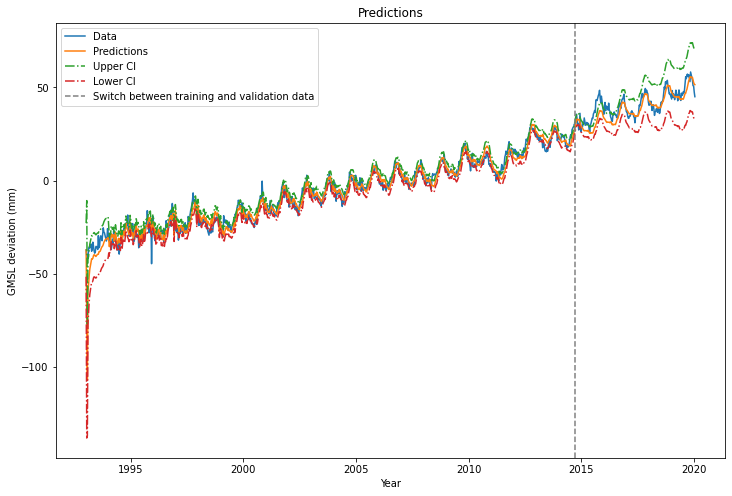

In [23]:
# Plot the data and predictions
plt.plot(u, y, label='Data')
plt.plot(u, kf.y_pred, label='Predictions')
plt.plot(u, kf.y_pred + np.sqrt(kf.F_pred), label='Upper CI', ls='-.')
plt.plot(u, kf.y_pred - np.sqrt(kf.F_pred), label='Lower CI', ls='-.')
plt.axvline(x=u[n], color='grey', ls='--', label='Switch between training and validation data')
plt.title('Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')

In [24]:
# Log-likelihood of training data based on updated filter predictions 
llik = log_likelihood(y=y[:n], y_hat=kf.y_pred[:n], F=kf.F_pred[:n])
print("The log-likelihood of the training data : ", llik)

# Log-likelihood of validation data based on updated filter predictions
llik = log_likelihood(y=y[n:], y_hat=kf.y_pred[n:], F=kf.F_pred[n:])
print("The log-likelihood of the validation data : ", llik)

The log-likelihood of the training data :  -2112.0321419185084
The log-likelihood of the validation data :  -1227.305036587401


Note that we can view the model for the data $y_t$ as being comprised of an underlying "signal", $s_t = \mu_t + \gamma_t$ plus observation noise $\varepsilon_t$

\begin{align}
    y_t = s_t + \varepsilon_t
\end{align}

We can obtain refined, _smoothed,_ estimates of this signal by conditioning on all the training data $y_{1:n}$. 

**Q14:** Run a Kalman smoother to compute smoothed estimates of the signal, $\mathbb{E}[s_t | y_{1:n}]$, conditionally on all the _training data_. Then, similarly to above, plot the following:
1. The data $y_{1:n+m}$,
2. The smoothed estimates $\mathbb{E}[s_t | y_{1:n}] \pm 1$ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The predictions $\mathbb{E}[s_t | y_{1:n}] \pm 1$ standard deviation for the validation data, i.e., $t = n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using, e.g., `plt.axvline(x=u[n])`.

_Hint:_ Express $s_t$ in terms of $\alpha_t$. Based on this expression, compute the smoothed mean and variance of $s_t$ based on the smoothed mean and covariance of $\alpha_t$.

In [25]:
# Run the kalman smoother using updated model
y_new = np.concatenate((y[:n], np.repeat(np.nan, m)))
ks = kalman_smoother(y=y_new, model=model, kf=kf)

# Get smoothed estimates of the signal
y_pred = np.ndarray(ndata)
for t in range(ndata):
    y_pred[t] = model.Z.dot(ks.alpha_sm[:, :, t])

Text(0, 0.5, 'GMSL deviation (mm)')

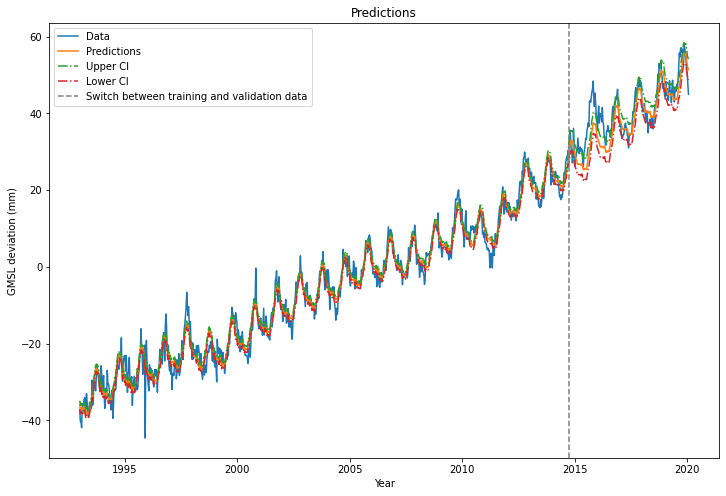

In [26]:
# Plot the data and smoothed estimates
plt.plot(u, y, label='Data')
plt.plot(u, y_pred, label='Predictions')
plt.plot(u, y_pred + np.sqrt(ks.eps_var), label='Upper CI', ls='-.')
plt.plot(u, y_pred - np.sqrt(ks.eps_var), label='Lower CI', ls='-.')
plt.axvline(x=u[n], color='grey', ls='--', label='Switch between training and validation data')
plt.title('Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')

In [27]:
# Log-likelihood of training data based on kalman smoother predictions using updated model
llik = log_likelihood(y=y[:n], y_hat=y_pred[:n], F=ks.eps_var[:n])
print("The log-likelihood of the training data : ", llik)

# Log-likelihood of validation data based on kalman smoother predictions using updated model
llik = log_likelihood(y=y[n:], y_hat=y_pred[n:], F=ks.eps_var[n:])
print("The log-likelihood of the validation data : ", llik)

The log-likelihood of the training data :  -4488.68214451553
The log-likelihood of the validation data :  -1184.1845001726308


**Q15:** Explain, using a few sentences, the qualitative differences (or similarities) between the Kalman filter predictions plotted in **Q13** and the smoothed signal estimates plotted in **Q14** for,
1. Training data points, $t \leq n$
2. Validation data points, $t > n$

**A:** The kalman smoother gives better starting predictions than the kalman filter. But we noticed a decrease in the log-likelihood of the smoother when compared to the filter on the training data. This result was a bit surprising. We expected better estimates from smoothing since it uses all the data and adds a backward pass on top of filtering. 

However, both the smoothed and filter estimates are quite similar on the validation data, with the log-likelihood of kalman smoother slightly better than that of the kalman filter on validation data. The confidence intervals were also found to be tighter for the smoothed estimates.

We can shed additional light on the properties of the process under study by further decomposing the signal into its trend and seasonal components.

**Q16:** Using the results of the state smoother, compute and plot the _smoothed estimates_ of the two signal components, i.e.:

1. Trend: $\hat \mu_{t|n} = \mathbb{E}[\mu_t | y_{1:n}]$ for $t = 1,\dots,n$
2. Seasonal: $\hat \gamma_{t|n} = \mathbb{E}[\gamma_t | y_{1:n}]$ for $t = 1,\dots,n$

_(You don't have to include confidence intervals here if don't want to, for brevity.)_

Text(0, 0.5, 'GMSL deviation (mm)')

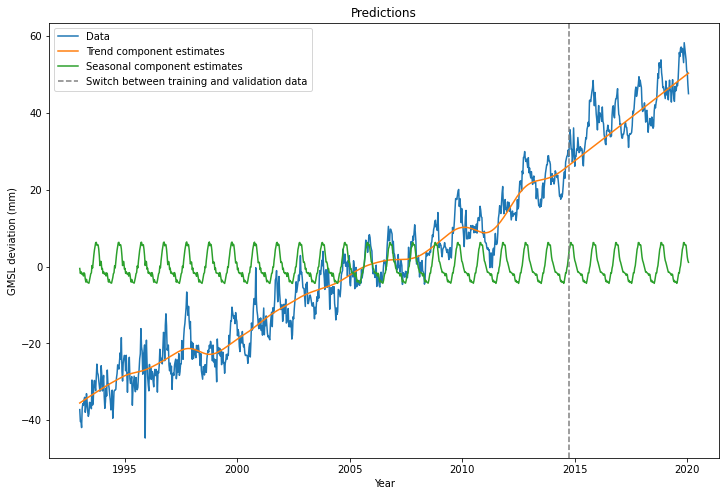

In [28]:
# Compute the trend and seasonal components from smoothed mean of states
mu_hat    = np.ndarray(ndata)
gamma_hat = np.ndarray(ndata)

# Compute 
for t in range(ndata):
    mu_hat[t]    = Z_mu.dot(ks.alpha_sm[:k, :, t])
    gamma_hat[t] = Z_gamma.dot(ks.alpha_sm[k:, :, t])

# Plot the data and smoothed estimates of trend and seasonal components
plt.plot(u, y, label='Data')
plt.plot(u, mu_hat, label='Trend component estimates')
plt.plot(u, gamma_hat, label='Seasonal component estimates')
plt.axvline(x=u[n], color='grey', ls='--', label='Switch between training and validation data')
plt.title('Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')

## 2.5 Missing data
We conclude this section by illustrating one of the key merits of the state space approach to time series analysis, namely the simplicity of handling missing data. To this end we will assume that a chunk of observations in the middle of the training data is missing.

**Q17:** Let the values $y_{t}$ for $ 300 < t \leq 400$ be missing (set to `np.nan`). Modify the data and rerun the Kalman filter and smoother. Plot,
1. The Kalman filter predictions, analogously to **Q8**
2. The Kalman smoother predictions, analogously to **Q13**

Comment on the qualitative differences between the filter and smoother estimates and explain what you see (in a couple of sentences).

Text(0, 0.5, 'GMSL deviation (mm)')

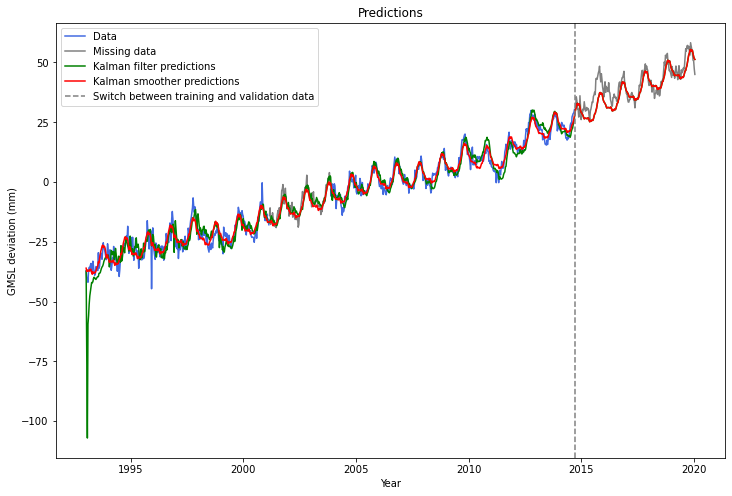

In [29]:
# Set observations from t=300 to t=400 to NaNs and predict using kalman filter and smoother
y_new = np.concatenate((y[:300], np.repeat(np.nan, 100), y[400:n], np.repeat(np.nan, m)))

# Kalman filter predictions
kf = kalman_filter(y=y_new, model=model)

# Kalman smoother predictions
ks = kalman_smoother(y=y_new, model=model, kf=kf)
ks_y_pred = np.ndarray(len(y_new))
for t in range(len(y_new)):
    ks_y_pred[t] = model.Z.dot(ks.alpha_sm[:, :, t])
    
# Plot the missing data along with the kalman filter predictions and smoother predictions
plt.plot(u[:300], y[:300], label='Data', color='royalblue')
plt.plot(u[300:400], y[300:400], label='Missing data', color='grey')
plt.plot(u[400:n], y[400:n], color='royalblue')
plt.plot(u[n:], y[n:], color='grey')
plt.plot(u, kf.y_pred, label='Kalman filter predictions', color='green')
plt.plot(u, ks_y_pred, label='Kalman smoother predictions', color='red')
plt.axvline(x=u[n], color='grey', ls='--', label='Switch between training and validation data')
plt.title('Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')

We see that the filter and smoother predictions are almost exactly the same on the missing validation data (we observed a slight increase in the log-likelihood of the the smoother compared to the filter). Since we are essentially performing online predictions i.e. predicting the current time point based on all the previous time points upto the current one, kalman filtering is sufficient in this scenario. Furthermore, smoothing would achieve the same results as the filtering because the additional backpass through the data in smoothing does not add any new information and hence the quality of predictions is the same.

## Appendix A. Why didn't we learn the trend noise variance as well?
In the assignment above we have fixed $\sigma_\mu$ to a small value. Conceptually it would have been straightforward to learn also this parameter with the EM algorithm. However, unfortunately, the maximum likelihood estimate of $\sigma_\mu$ often ends up being too large to result in accurate _long term predictions_. The reason for this issue is that the structural model

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

is not a perfect description of reality. As a consequence, when learning the parameters the mismatch between the model and the data is compensated for by increasing the noise variances. This results in a trend component which does not only capture the long term trends of the data, but also seemingly random variations due to a model misspecification, possibly resulting in poor _long range predictions_.

Kitagawa (Introduction to Time Series Modeling, CRC Press, 2010, Section 12.3) discusses this issue and proposes two solutions. The first is a simple and pragmatic one: simply fix $\sigma_\mu^2$ to a value smaller than the maximum likelihood estimate. This is the approach we have taken in this assignment. The issue is of course that in practice it is hard to know what value to pick, which boild down to manual trial and error (or, if you are lucky, the designer of the lab assignment will tell you which value to use!).

The second, more principled, solution proposed by Kitagawa is to augment the model with a stationary AR component as well. That is, we model

\begin{align}
    y_t = \mu_t + \gamma_t + \nu_t + \varepsilon_t
\end{align}

where $\nu_t \sim$ AR$(p)$. By doing so, the stationary AR component can compensate for the discrepancies between the original structural model and the "true data generating process". It is straightforward to include this new component in the state space representation (how?) and to run the Kalman filter and smoother on the resulting model. Indeed, this is one of the beauties with working with the state space representation of time series data! However, the M-step of the EM algorithm becomes a bit more involved if we want to use the method to estimate also the AR coefficients of the $\nu$-component, which is beyond the scope of this lab assignment.